## **Parcial final parte práctica**


### **El Problema**

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

# **Predicciones de ventas**

Examen final Fundamentos de Analítica II - Series de Tiempo

- Raul Echeverry<br>
- Esteban Ordoñez


## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from itertools import product
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import itertools
from pandas.tseries.offsets import MonthBegin
from statsmodels.sandbox.stats.runs import runstest_1samp
import pylab as py
from scipy import stats
import seaborn as sns
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## **2. Carga de datos**
Empleando la información de las ventas en unidades de una mepresa de comestibles. Las ventas estan expresadas en unidades mensuales desde enero de 2008, y se tiene los dos productos estrellas de la empresa.

In [2]:
url = "https://raw.githubusercontent.com/leoe21/Data_Science/main/Series_de_Tiempo_Comparaci%C3%B3n_Modelos/Ventas_unidades.csv"

data = pd.read_csv(url)
data.index = pd.date_range(start='2008-01-31', periods=len(data), freq='ME')
data.drop("Unnamed: 0", axis=1, inplace=True)
data

,producto1,producto2
2008-01-31,4000.000000,3000.000000
2008-02-29,3997.400893,3010.686220
2008-03-31,3978.605317,3022.018584
2008-04-30,3986.454125,3033.920990
2008-05-31,3979.695678,3038.402098
...,...,...
2018-03-31,3664.610771,3429.293034
2018-04-30,3650.881839,3437.099467
2018-05-31,3651.788470,3453.155282
2018-06-30,3637.047639,3472.528345


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica las ventas de producto 1 y producto 2

(127, 2)


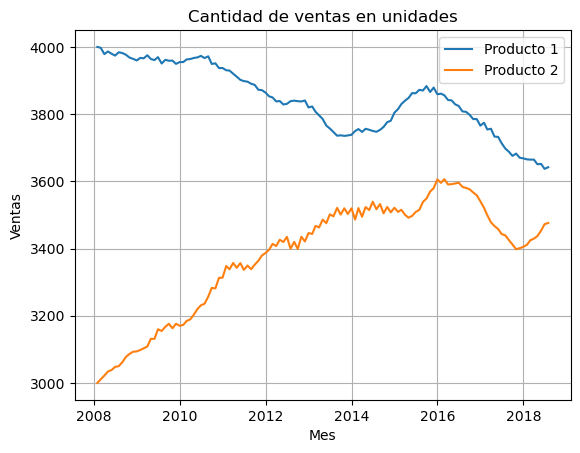

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Cantidad de ventas en unidades")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.plot(data[["producto1"]], label="Producto 1")
plt.plot(data[["producto2"]], label="Producto 2")
plt.legend()
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

### **3.1. Componentes de la serie de tiempo del Producto 1**

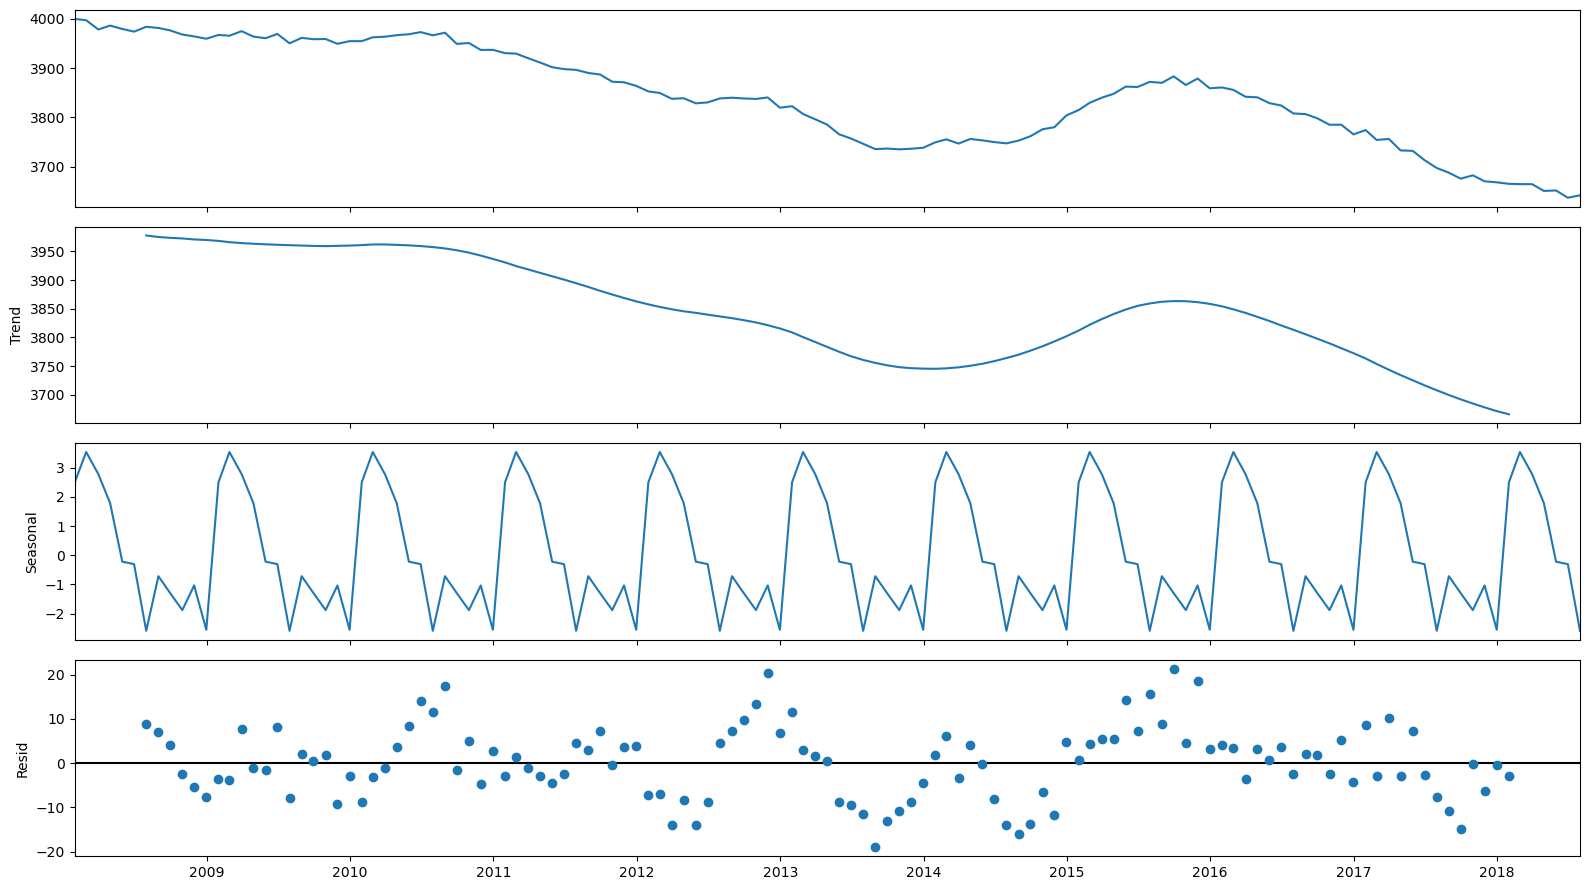

In [4]:
td_componentes = seasonal_decompose(data[["producto1"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con el modelado, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

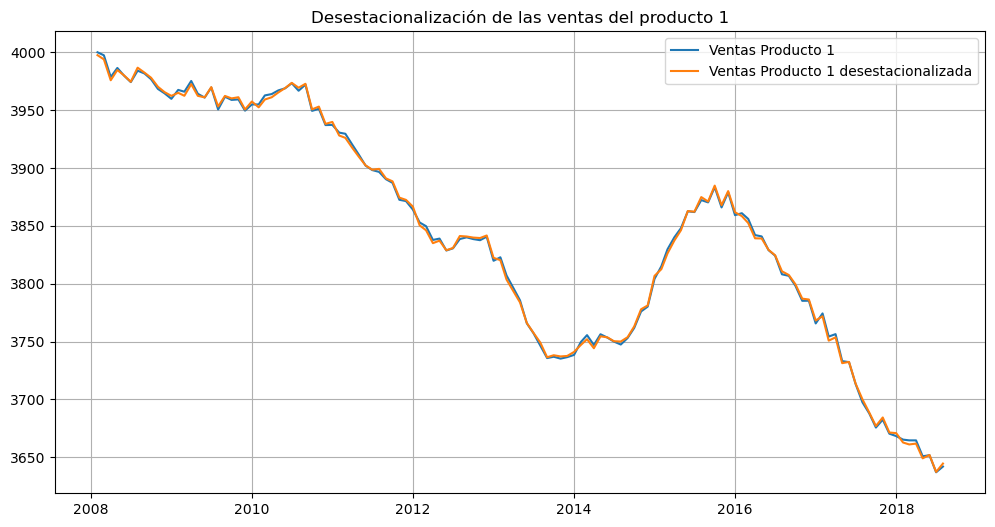

In [5]:
td_desestacionalizada = data["producto1"]-td_componentes.seasonal
fig = plt.figure(figsize=(12, 6))
plt.title("Desestacionalización de las ventas del producto 1")
plt.plot(data[["producto1"]],label="Ventas Producto 1")
plt.plot(td_desestacionalizada,label="Ventas Producto 1 desestacionalizada")
plt.legend()
plt.grid()
plt.show()

### **3.2. Componentes de la serie de tiempo del Producto 2**

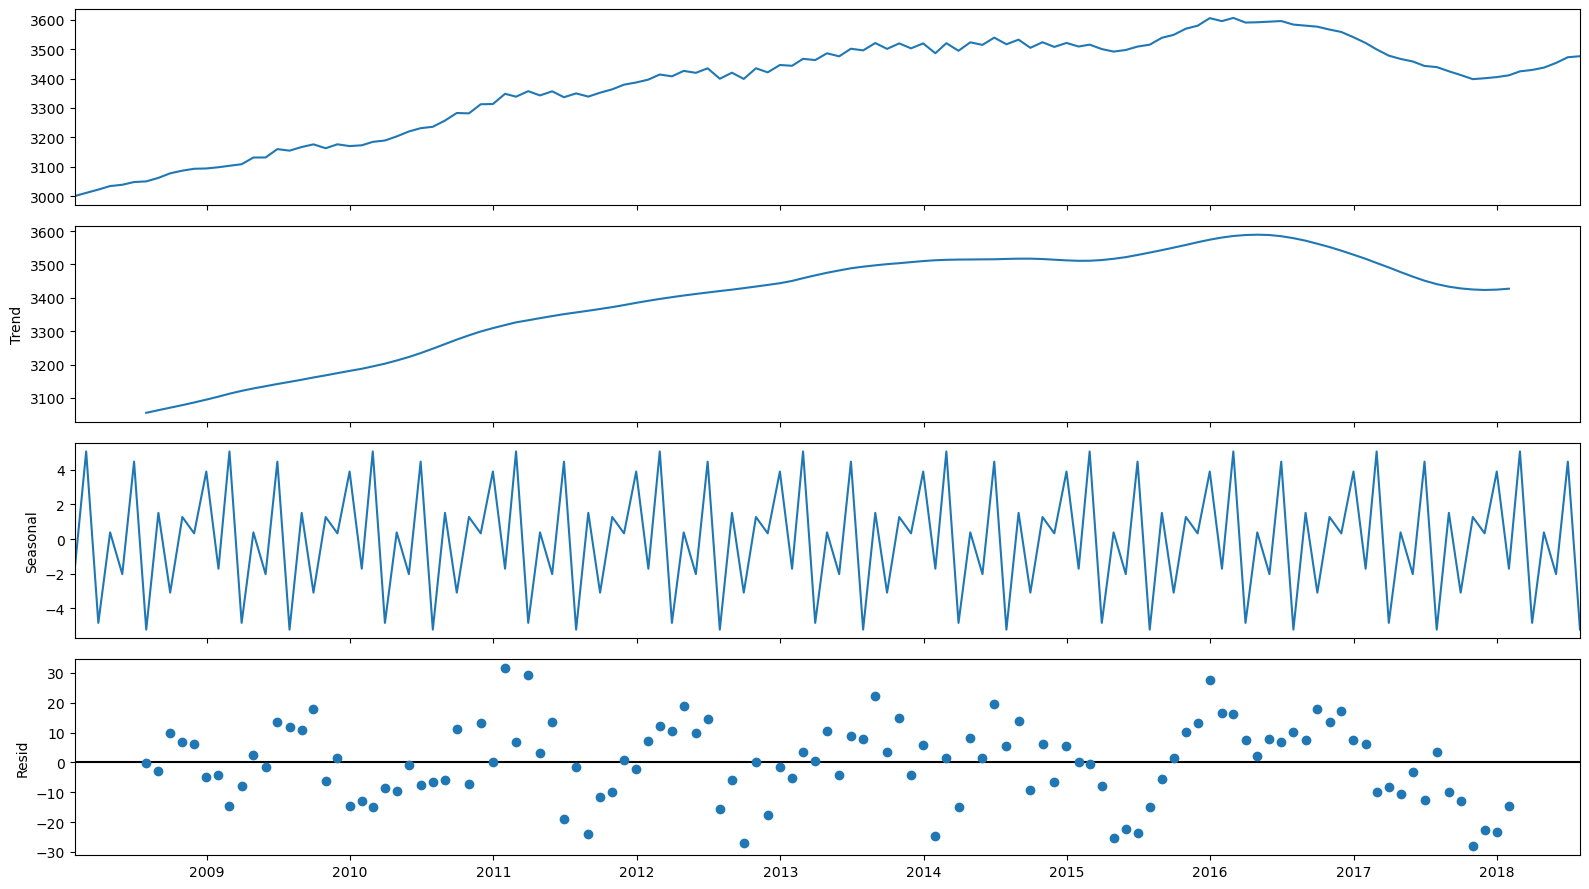

In [6]:
td_componentes = seasonal_decompose(data[["producto2"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

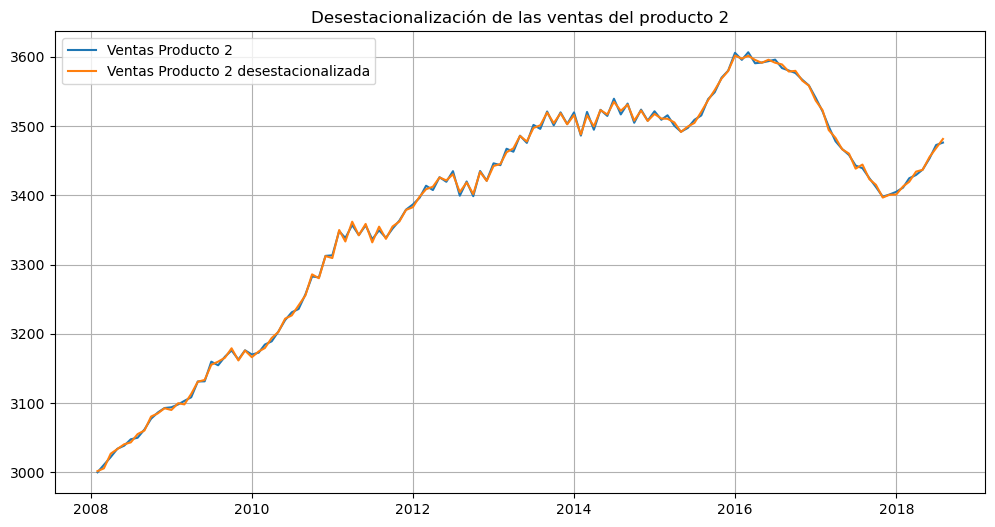

In [7]:
td_desestacionalizada = data["producto2"]-td_componentes.seasonal
fig = plt.figure(figsize=(12, 6))
plt.title("Desestacionalización de las ventas del producto 2")
plt.plot(data[["producto2"]],label="Ventas Producto 2")
plt.plot(td_desestacionalizada,label="Ventas Producto 2 desestacionalizada")
plt.legend()
plt.grid()
plt.show()

## **4. Protocolos de evaluación**

**Backtesting con Walk-Forward Validation**</br>
Para evaluar el rendimiento de los modelos predictivos en esta serie temporal, implementaremos un protocolo de backtesting basado en walk-forward validation, aplicando dos variantes: ventana móvil y ventana recursiva.

### **4.1. Walk-Forward Validation con Ventana Recursiva**
El enfoque de ventana recursiva emplea un conjunto de entrenamiento que se expande progresivamente a medida que avanzamos en el tiempo. En cada iteración, el modelo se reentrena incluyendo todos los datos históricos disponibles hasta ese punto, sin eliminar ningún dato anterior. Este método es adecuado para capturar tanto patrones a corto como a largo plazo, ya que utiliza toda la información histórica para hacer predicciones, proporcionando así una visión más completa de la serie temporal.

![Backtesting con Reentrenamiento](https://cienciadedatos.net/images/backtesting_refit.gif)
<sub>*(Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y reentrenamiento en cada iteración.)*</sub>

### **4.2. Walk-Forward Validation con Ventana Móvil**
En el enfoque de ventana móvil, el modelo se entrena utilizando una ventana de datos de tamaño constante que se desplaza a lo largo del tiempo. En cada iteración, los datos más antiguos se eliminan y se añaden los datos más recientes, manteniendo un conjunto de entrenamiento de tamaño fijo. Este método es ideal para capturar cambios recientes en la serie temporal, ya que prioriza la información más actual y permite una rápida adaptación a nuevos patrones.

![Backtesting con reentrenamiento y tamaño de entrenamiento constante](https://cienciadedatos.net/images/backtesting_refit_fixed_train_size.gif)
<sub>*(Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y set de entrenamiento con tamaño constante.)*</sub>

Fuente: [Skforecast: forecasting series temporales con Python, Machine Learning y Scikit-learn](https://cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn).












## **5. Modelado**

### **5.1. Suavizacion Exponencial Simple, Suavizacion Exponencial Lineal (Holt) y Suavizacion Exponencial Lineal de Winters (Holt-Winters)** 

### **a. Ventana recursiva**

Probando con error=add, trend=add, seasonal=add
Probando con error=add, trend=add, seasonal=mul
Probando con error=add, trend=add, seasonal=None
Probando con error=add, trend=mul, seasonal=add
Probando con error=add, trend=mul, seasonal=mul
Probando con error=add, trend=mul, seasonal=None
Probando con error=add, trend=None, seasonal=add
Probando con error=add, trend=None, seasonal=mul
Probando con error=add, trend=None, seasonal=None
Probando con error=mul, trend=add, seasonal=add
Probando con error=mul, trend=add, seasonal=mul
Probando con error=mul, trend=add, seasonal=None
Probando con error=mul, trend=mul, seasonal=add
Probando con error=mul, trend=mul, seasonal=mul
Probando con error=mul, trend=mul, seasonal=None
Probando con error=mul, trend=None, seasonal=add
Probando con error=mul, trend=None, seasonal=mul
Probando con error=mul, trend=None, seasonal=None
Mejores hiperparámetros: error=mul, trend=mul, seasonal=add
Mejor RMSE: 52.87916947448709


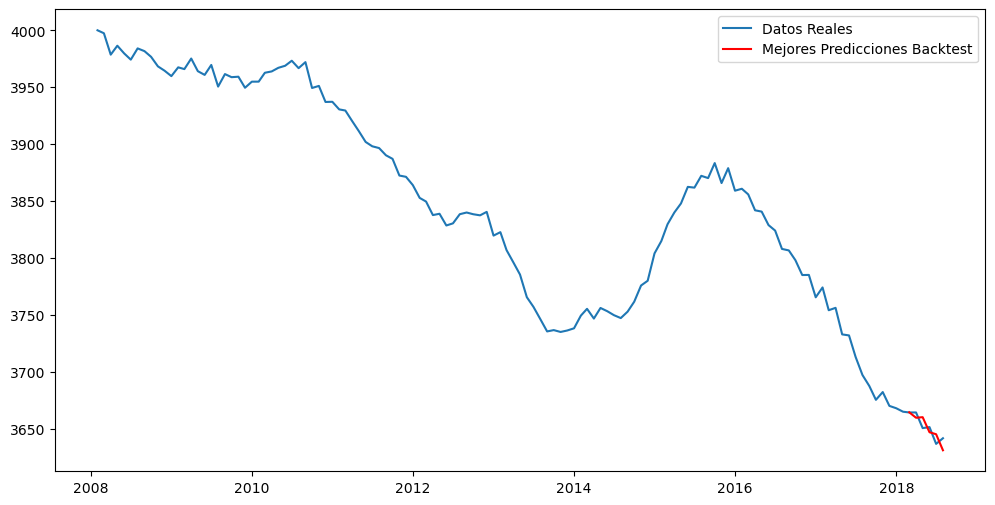

In [8]:
# Definir el horizonte de predicción y la ventana de backtesting
steps = 1  # Número de pasos hacia adelante que quieres predecir
n_backtesting = 6  # Número de pasos hacia atrás que quieres usar para backtesting

# Preparar los datos
y = data["producto1"]

# Listas de posibles valores de hiperparámetros
error_options = ["add", "mul"]
trend_options = ["add", "mul", None]
seasonal_options = ["add", "mul", None]

# Definir combinaciones de hiperparámetros
param_grid = list(product(error_options, trend_options, seasonal_options))

# Función de backtesting con hiperparámetros
def backtesting_forecaster(forecaster, y, initial_train_size, steps, metric, error, trend, seasonal):
    predictions = []
    true_values = []
    
    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[:i]  # Ventana Recursiva
        test_y = y[i:i+steps]
        
        # Crear un nuevo modelo para cada iteración con los hiperparámetros actuales
        forecaster = ETSModel(endog=train_y, 
                              error=error, 
                              trend=trend, 
                              seasonal=seasonal, 
                              seasonal_periods=12)
        
        ets_result = forecaster.fit()
        pred = ets_result.forecast(steps)
        
        predictions.extend(pred)
        true_values.extend(test_y)
    
    if metric == 'mean_squared_error':
        return mean_squared_error(true_values, predictions), predictions, true_values
    
# Inicializar lista para almacenar resultados
results = []

# Buscar los mejores hiperparámetros
best_rmse = float("inf")
best_params = None
best_predictions = None

for params in param_grid:
    error, trend, seasonal = params
    print(f"Probando con error={error}, trend={trend}, seasonal={seasonal}")
    
    metrica, predicciones_backtest, valores_reales = backtesting_forecaster(
                                        forecaster         = None,
                                        y                  = y,
                                        initial_train_size = len(y) - n_backtesting,
                                        steps              = steps,
                                        metric             = 'mean_squared_error',
                                        error              = error,
                                        trend              = trend,
                                        seasonal           = seasonal
                                     )
    # Guardar los resultados en la lista
    results.append({
        "Error": error,
        "Trend": trend,
        "Seasonal": seasonal,
        "RMSE": metrica
    })

    if metrica < best_rmse:
        best_rmse = metrica
        best_params = params
        best_predictions = predicciones_backtest

# Convertir la lista de resultados a un DataFrame
results_df = pd.DataFrame(results)


print(f"Mejores hiperparámetros: error={best_params[0]}, trend={best_params[1]}, seasonal={best_params[2]}")
print(f"Mejor RMSE: {best_rmse}")

# Graficar los resultados del mejor modelo
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, label='Datos Reales')
ax.plot(y.index[len(y) - len(best_predictions):], best_predictions, label='Mejores Predicciones Backtest', color='red')
ax.legend()
plt.show()


In [9]:
results_df
results_df.style.bar(subset=['RMSE'], align='mid', color=['#d65f5f','#5fba7d'])

,Error,Trend,Seasonal,RMSE
0,add,add,add,56.212549
1,add,add,mul,54.829165
2,add,add,None,56.397468
3,add,mul,add,55.638940
4,add,mul,mul,55.269277
5,add,mul,None,56.251337
6,add,None,add,76.951548
7,add,None,mul,77.106167
8,add,None,None,71.905912
9,mul,add,add,56.006939


### **b. Ventana Movil**

Probando con error=add, trend=add, seasonal=add
Probando con error=add, trend=add, seasonal=mul
Probando con error=add, trend=add, seasonal=None
Probando con error=add, trend=mul, seasonal=add
Probando con error=add, trend=mul, seasonal=mul
Probando con error=add, trend=mul, seasonal=None
Probando con error=add, trend=None, seasonal=add
Probando con error=add, trend=None, seasonal=mul
Probando con error=add, trend=None, seasonal=None
Probando con error=mul, trend=add, seasonal=add
Probando con error=mul, trend=add, seasonal=mul
Probando con error=mul, trend=add, seasonal=None
Probando con error=mul, trend=mul, seasonal=add
Probando con error=mul, trend=mul, seasonal=mul
Probando con error=mul, trend=mul, seasonal=None
Probando con error=mul, trend=None, seasonal=add
Probando con error=mul, trend=None, seasonal=mul
Probando con error=mul, trend=None, seasonal=None
Mejores hiperparámetros: error=add, trend=mul, seasonal=add
Mejor RMSE: 52.76736567162407


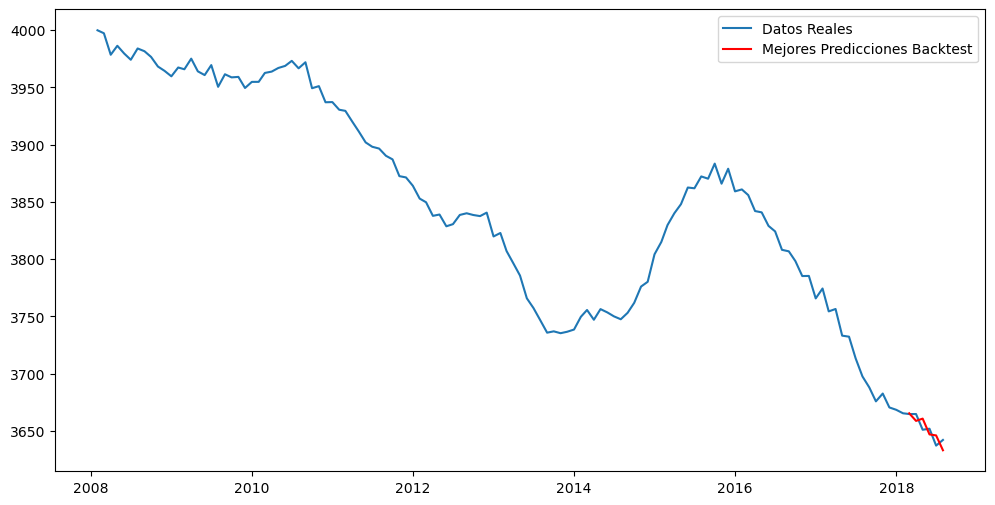

In [10]:
# Función de backtesting con hiperparámetros
def backtesting_forecaster(forecaster, y, initial_train_size, steps, metric, error, trend, seasonal):
    predictions = []
    true_values = []
    
    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[i - initial_train_size:i] # Ventana movil
        test_y = y[i:i+steps]
        
        # Crear un nuevo modelo para cada iteración con los hiperparámetros actuales
        forecaster = ETSModel(endog=train_y, 
                              error=error, 
                              trend=trend, 
                              seasonal=seasonal, 
                              seasonal_periods=12)
        
        ets_result = forecaster.fit()
        pred = ets_result.forecast(steps)
        
        predictions.extend(pred)
        true_values.extend(test_y)
    
    if metric == 'mean_squared_error':
        return mean_squared_error(true_values, predictions), predictions, true_values

# Buscar los mejores hiperparámetros
best_rmse = float("inf")
best_params = None
best_predictions = None

for params in param_grid:
    error, trend, seasonal = params
    print(f"Probando con error={error}, trend={trend}, seasonal={seasonal}")
    
    metrica, predicciones_backtest, valores_reales = backtesting_forecaster(
                                        forecaster         = None,
                                        y                  = y,
                                        initial_train_size = len(y) - n_backtesting,
                                        steps              = steps,
                                        metric             = 'mean_squared_error',
                                        error              = error,
                                        trend              = trend,
                                        seasonal           = seasonal
                                     )
    
    if metrica < best_rmse:
        best_rmse = metrica
        best_params = params
        best_predictions = predicciones_backtest

print(f"Mejores hiperparámetros: error={best_params[0]}, trend={best_params[1]}, seasonal={best_params[2]}")
print(f"Mejor RMSE: {best_rmse}")

# Graficar los resultados del mejor modelo
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, label='Datos Reales')
ax.plot(y.index[len(y) - len(best_predictions):], best_predictions, label='Mejores Predicciones Backtest', color='red')
ax.legend()
plt.show()


Mean Squared Error: 54.403678243491065


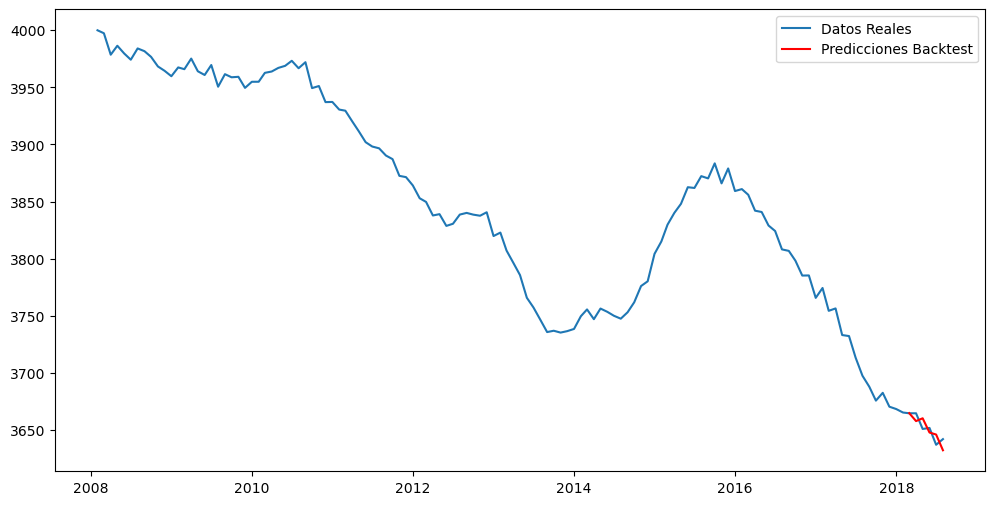

In [11]:
# Definir el horizonte de predicción y la ventana de backtesting
steps = 1  # Número de pasos hacia adelante que quieres predecir
n_backtesting = 6 # Número de pasos hacia atrás que quieres usar para backtesting

# Preparar los datos
y = data["producto1"]


# Función de backtesting
def backtesting_forecaster(forecaster, y, initial_train_size, steps, metric):
    predictions = []
    true_values = []
    
    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[:i] # Ventana Recursiva
        test_y = y[i:i+steps]
        
        # Crear un nuevo modelo para cada iteración

        forecaster = ETSModel(endog=train_y, 
                              error='mul', 
                              trend='add', 
                              seasonal='mul', 
                              seasonal_periods=12)
        
        ets_result = forecaster.fit()
        pred = ets_result.forecast(steps)
        
        predictions.extend(pred)
        true_values.extend(test_y)
    
    if metric == 'mean_squared_error':
        return mean_squared_error(true_values, predictions), predictions, true_values

# Ejecutar el backtesting
metrica, predicciones_backtest, valores_reales = backtesting_forecaster(
                                    forecaster         = None,
                                    y                  = y,
                                    initial_train_size = len(y) - n_backtesting,
                                    steps              = steps,
                                    metric             = 'mean_squared_error'
                                 )

# Mostrar los resultados
print(f"Mean Squared Error: {metrica}")

# Graficar los resultados del backtesting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, label='Datos Reales')
ax.plot(y.index[len(y) - len(predicciones_backtest):], predicciones_backtest, label='Predicciones Backtest', color='red')
ax.legend()
plt.show()

## **Optimización Bayesiana**

In [17]:
error_options = ["add", "mul"]
trend_options = ["add", "mul", None]
seasonal_options = ["add", "mul", None]

In [19]:
pbounds = {
    'error_idx': (0, len(error_options) - 1),
    'trend_idx': (0, len(trend_options) - 1),
    'seasonal_idx': (0, len(seasonal_options) - 1)
}


In [20]:
def ets_objective(error_idx, trend_idx, seasonal_idx):
    # Convertir los índices a valores categóricos
    error = error_options[int(round(error_idx))]
    trend = trend_options[int(round(trend_idx))]
    seasonal = seasonal_options[int(round(seasonal_idx))]

    # Realizar el backtesting con los valores actuales
    metrica, _, _ = backtesting_forecaster(
        y=y,
        initial_train_size=len(y) - n_backtesting,
        steps=steps,
        metric='mean_squared_error',
        error=error,
        trend=trend,
        seasonal=seasonal
    )
    
    # Negar la métrica para maximizar
    return -metrica

In [21]:
# Iniciar la optimización bayesiana
optimizer = BayesianOptimization(
    f=ets_objective,
    pbounds=pbounds,
    random_state=42,
)

# Ejecutar la optimización
optimizer.maximize(
    init_points=10,  # Número de puntos iniciales
    n_iter=25        # Número de iteraciones de optimización
)

# Mostrar los mejores parámetros
best_error_idx = int(round(optimizer.max['params']['error_idx']))
best_trend_idx = int(round(optimizer.max['params']['trend_idx']))
best_seasonal_idx = int(round(optimizer.max['params']['seasonal_idx']))

print("Mejores parámetros:")
print(f"Error: {error_options[best_error_idx]}")
print(f"Trend: {trend_options[best_trend_idx]}")
print(f"Seasonal: {seasonal_options[best_seasonal_idx]}")
print(f"Mejor RMSE: {-optimizer.max['target']}")

|   iter    |  target   | error_idx | season... | trend_idx |
-------------------------------------------------------------
| 1         | -56.14    | 0.3745    | 1.901     | 1.464     |
| 2         | -54.72    | 0.5987    | 0.312     | 0.312     |
| 3         | -56.14    | 0.05808   | 1.732     | 1.202     |
| 4         | -75.07    | 0.7081    | 0.04117   | 1.94      |
| 5         | -54.72    | 0.8324    | 0.4247    | 0.3636    |
| 6         | -54.3     | 0.1834    | 0.6085    | 1.05      |
| 7         | -54.3     | 0.4319    | 0.5825    | 1.224     |
| 8         | -54.3     | 0.1395    | 0.5843    | 0.7327    |
| 9         | -56.23    | 0.4561    | 1.57      | 0.3993    |
| 10        | -53.9     | 0.5142    | 1.185     | 0.0929    |
| 11        | -54.12    | 1.0       | 1.21      | 1.06      |
| 12        | -56.34    | 1.0       | 2.0       | 0.0       |
| 13        | -71.91    | 1.0       | 2.0       | 2.0       |
| 14        | -67.52    | 0.0       | 0.0       | 0.0       |
| 15    

In [22]:
optimizer.max

{'target': -52.76736567162407,
 'params': {'error_idx': 0.23264919561989608,
  'seasonal_idx': 0.0,
  'trend_idx': 0.952076097837257}}

In [23]:
def backtesting_forecaster(y, initial_train_size, steps, metric, error, trend, seasonal):
    predictions = []
    true_values = []
    
    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[i - initial_train_size:i]  # Ventana móvil
        test_y = y[i:i + steps]
        
        # Crear un nuevo modelo para cada iteración con los hiperparámetros actuales
        forecaster = ETSModel(endog=train_y, 
                              error=error, 
                              trend=trend, 
                              seasonal=seasonal, 
                              seasonal_periods=12)
        
        ets_result = forecaster.fit()
        pred = ets_result.forecast(steps)
        
        predictions.extend(pred)
        true_values.extend(test_y)
    
    if metric == 'mean_squared_error':
        return mean_squared_error(true_values, predictions), predictions, true_values

In [24]:
# Función objetivo corregida
def ets_objective(error_idx, trend_idx, seasonal_idx):
    # Convertir los índices de los hiperparámetros a sus valores correspondientes
    error = error_options[int(round(error_idx))]
    trend = trend_options[int(round(trend_idx))]
    seasonal = seasonal_options[int(round(seasonal_idx))]

    # Crear y ajustar el modelo ETS usando los parámetros actuales
    metrica, _, _ = backtesting_forecaster(
        y=y,
        initial_train_size=len(y) - n_backtesting,
        steps=steps,
        metric='mean_squared_error',
        error=error,
        trend=trend,
        seasonal=seasonal
    )
    
    # Negar la métrica porque la optimización bayesiana maximiza
    return -metrica

In [25]:
# Definir los espacios de búsqueda como índices de los valores posibles
pbounds = {
    'error_idx': (0, len(error_options) - 1),
    'trend_idx': (0, len(trend_options) - 1),
    'seasonal_idx': (0, len(seasonal_options) - 1)
}

# Iniciar la optimización bayesiana
optimizer = BayesianOptimization(
    f=ets_objective,
    pbounds=pbounds,
    random_state=42,
)

# Ejecutar la optimización
optimizer.maximize(
    init_points=3,
    n_iter=40,
)

# Mostrar los mejores parámetros
print(optimizer.max)

|   iter    |  target   | error_idx | season... | trend_idx |
-------------------------------------------------------------
| 1         | -56.14    | 0.3745    | 1.901     | 1.464     |
| 2         | -54.72    | 0.5987    | 0.312     | 0.312     |
| 3         | -56.14    | 0.05808   | 1.732     | 1.202     |
| 4         | -57.13    | 1.0       | 0.0       | 1.203     |
| 5         | -54.72    | 0.6129    | 0.3263    | 0.3263    |
| 6         | -54.1     | 0.4871    | 0.9175    | 0.0       |
| 7         | -56.34    | 1.0       | 1.725     | 0.0       |
| 8         | -54.1     | 0.0       | 0.7213    | 0.0       |
| 9         | -54.1     | 0.0       | 1.353     | 0.0       |
| 10        | -54.3     | 0.0       | 0.8889    | 0.5144    |
| 11        | -54.72    | 1.0       | 0.4847    | 0.0       |
| 12        | -76.17    | 0.0       | 0.5271    | 2.0       |
| 13        | -56.25    | 1.0       | 2.0       | 0.9543    |
| 14        | -56.23    | 0.0       | 2.0       | 0.4185    |
| 15    

In [15]:
optimizer.max

{'target': -52.76736567162407,
 'params': {'error_idx': 0.4776468084809959,
  'seasonal_idx': 0.0,
  'trend_idx': 0.823972664835342}}

In [16]:
# Función objetivo corregida
def ets_objective(error_idx, trend_idx, seasonal_idx):
    # Convertir los índices de los hiperparámetros a sus valores correspondientes
    error = error_options[int(round(error_idx))]
    trend = trend_options[int(round(trend_idx))]
    seasonal = seasonal_options[int(round(seasonal_idx))]

    # Crear y ajustar el modelo ETS usando los parámetros actuales
    metrica, _, _ = backtesting_forecaster(
        forecaster=None,
        y=y,
        initial_train_size=len(y) - n_backtesting,
        steps=steps,
        metric='mean_squared_error',
        error=error,
        trend=trend,
        seasonal=seasonal
    )
    
    # Negar la métrica porque la optimización bayesiana maximiza
    return -metrica

# Definir los espacios de búsqueda como índices de los valores posibles
pbounds = {
    'error_idx': (0, len(error_options) - 1),
    'trend_idx': (0, len(trend_options) - 1),
    'seasonal_idx': (0, len(seasonal_options) - 1)
}

# Iniciar la optimización bayesiana
optimizer = BayesianOptimization(
    f=ets_objective,
    pbounds=pbounds,
    random_state=42,
)

# Ejecutar la optimización
optimizer.maximize(
    init_points=10,
    n_iter=25,
)

# Mostrar los mejores parámetros
print(optimizer.max)

|   iter    |  target   | error_idx | season... | trend_idx |
-------------------------------------------------------------


TypeError: backtesting_forecaster() got an unexpected keyword argument 'forecaster'

In [ ]:
# Función objetivo
def ets_objective(error, trend, seasonal):
    error = error_options[int(round(error))]
    trend = trend_options[int(round(trend))]
    seasonal = seasonal_options[int(round(seasonal))]

    metrica, _, _ = backtesting_forecaster(
        forecaster=None,
        y=y,
        initial_train_size=len(y) - n_backtesting,
        steps=steps,
        metric='mean_squared_error',
        error=error,
        trend=trend,
        seasonal=seasonal
    )
    
    return -metrica  # Negamos la métrica porque la optimización bayesiana maximiza

# Definir los espacios de búsqueda
pbounds = {
    'error': (0, len(error_options) - 1),
    'trend': (0, len(trend_options) - 1),
    'seasonal': (0, len(seasonal_options) - 1)
}

# Iniciar la optimización bayesiana
optimizer = BayesianOptimization(
    f=ets_objective,
    pbounds=pbounds,
    random_state=42,
)

# Ejecutar la optimización
optimizer.maximize(
    init_points=10,
    n_iter=25,
)

# Mostrar los mejores parámetros
print(optimizer.max)

|   iter    |  target   |   error   | seasonal  |   trend   |
-------------------------------------------------------------


TypeError: backtesting_forecaster() got an unexpected keyword argument 'error'

In [ ]:
def train_and_evaluate_RMSE(initial_train_size, steps, error, trend, seasonal, alpha, beta, gamma):
    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    error_options = ["add", "mul"]
    trend_options = ["add", "mul", None]
    seasonal_options = ["add", "mul", None]

    predictions = []
    true_values = []

    for i in range(initial_train_size, len(train_o) - steps + 1, steps):
        train_y = train_o["producto1"][i - initial_train_size:i]  # Ventana móvil
        test_y = train_o["producto1"][i:i + steps]

        model = ETSModel(endog=train_y, 
                         error=error_options[round(error)], 
                         trend=trend_options[round(trend)], 
                         seasonal=seasonal_options[round(seasonal)])

        params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

        if trend_options[round(trend)] is None:
            params.pop('smoothing_trend')
        if seasonal_options[round(seasonal)] is None:
            params.pop('smoothing_seasonal')

        model_result = model.fit_constrained(params)
        point_forecast = model_result.forecast(steps)
        rmse = np.sqrt(mean_squared_error(test_y, point_forecast))

        predictions.extend(point_forecast)
        true_values.extend(test_y)

    return -rmse  # Negar el RMSE para maximizar

In [ ]:
pbounds = {
    'error': (0, 1),  # 0 para 'add', 1 para 'mul'
    'trend': (0, 2),  # 0 para 'add', 1 para 'mul', 2 para None
    'seasonal': (0, 2),  # 0 para 'add', 1 para 'mul', 2 para None
    'alpha': (0.01, 0.99),
    'beta': (0.01, 0.99),
    'gamma': (0.01, 0.99)
}

In [ ]:
initial_train_size = len(train_o) - 12  # Ajusta según tus datos
steps = 1

optimizer = BayesianOptimization(
    f=lambda error, trend, seasonal, alpha, beta, gamma: train_and_evaluate_RMSE(initial_train_size, steps, error, trend, seasonal, alpha, beta, gamma),
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

NameError: name 'train_o' is not defined

In [ ]:
import warnings
warnings.filterwarnings("ignore")

optimizer.maximize(init_points=5, n_iter=100)

# Mostrar los mejores resultados
print("Mejores hiperparámetros encontrados:")
print(optimizer.max)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------


NameError: name 'train_o' is not defined

In [ ]:
def train_and_evaluate_RMSE(initial_train_size, steps, error, trend, seasonal, alpha, beta, gamma):
    """Function we want to maximize (Black box)"""
    
    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]

    predictions = []
    true_values = []

    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[i - initial_train_size:i]  # Ventana movil
        test_y = y[i:i + steps]

        model = ETSModel(endog=train_y, 
                         error=error1[round(error)], 
                         trend=trend1[round(trend)], 
                         seasonal=seasonal1[round(seasonal)])

        params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

        if trend1[round(trend)] is None:
            params.pop('smoothing_trend')
        if seasonal1[round(seasonal)] is None:
            params.pop('smoothing_seasonal')

        model_result = model.fit_constrained(params)

        point_forecast = model_result.forecast(12)
        rmse = np.sqrt(mean_squared_error(test_y, point_forecast))

        predictions.extend(point_forecast)
        true_values.extend(test_y)

    return -rmse

In [ ]:
pbounds = {
    'error': (0, 1),
    'trend': (0, 2),
    'seasonal': (0, 2),
    'alpha': (0.01, 0.99),
    'beta': (0.01, 0.99),
    'gamma': (0.01, 0.99)
}

# Definir el tamaño inicial y los pasos
initial_train_size = len(y) - n_backtesting
steps = 1

optimizer = BayesianOptimization(
    f=lambda error, trend, seasonal, alpha, beta, gamma: train_and_evaluate_RMSE(initial_train_size, steps, error, trend, seasonal, alpha, beta, gamma),
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

# Ejecutar la optimización
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------


ValueError: Found input variables with inconsistent numbers of samples: [1, 12]

In [ ]:
initial_train_size = len(y) - n_backtesting
steps = 1

def train_and_evaluate_RMSE(error, trend, seasonal, alpha, beta, gamma):
    global initial_train_size, steps  # Hacer referencia a las variables globales

    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]

    predictions = []
    true_values = []

    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[i - initial_train_size:i]  # Ventana movil
        test_y = y[i:i + steps]

        model = ETSModel(endog=train_y, 
                         error=error1[round(error)], 
                         trend=trend1[round(trend)], 
                         seasonal=seasonal1[round(seasonal)])

        params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

        if trend1[round(trend)] is None:
            params.pop('smoothing_trend')
        if seasonal1[round(seasonal)] is None:
            params.pop('smoothing_seasonal')

        model_result = model.fit_constrained(params)

        point_forecast = model_result.forecast(12)
        rmse = np.sqrt(mean_squared_error(test_y, point_forecast))

        predictions.extend(point_forecast)
        true_values.extend(test_y)

    return -rmse

In [ ]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

NameError: name 'optimizer' is not defined

In [ ]:
optimizer.max

NameError: name 'optimizer' is not defined

In [ ]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma):
    """Function we want to maximize (Black box)

    It first trains a model with the training set using the received hyper
    parameterts, and then evaluatesand returns the Min RMSE over the test set.
    """
    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[i - initial_train_size:i] # Ventana movil
        test_y = y[i:i+steps]
        
    alpha = round(alpha,2)
    beta  = round(beta,2)
    gamma = round(gamma,2)

    print(error,trend,seasonal)
    print(alpha,beta,gamma)
    error1 = ["add","mul"]
    trend1 = ["add","mul",None]
    seasonal1 = ["add","mul",None]

    model = ETSModel(endog=train_y["Producto1"],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])

    params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

    if trend1[round(trend)] == None:
      params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] == None:
      params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast=model_result.forecast(12)
    rmse = np.sqrt(mean_squared_error(test_y["Producto1"],point_forecast ))

    print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
          format(rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

    return -rmse

In [ ]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------


NameError: name 'initial_train_size' is not defined

In [ ]:
optimizer.max

Mean Squared Error: 54.403678243491065


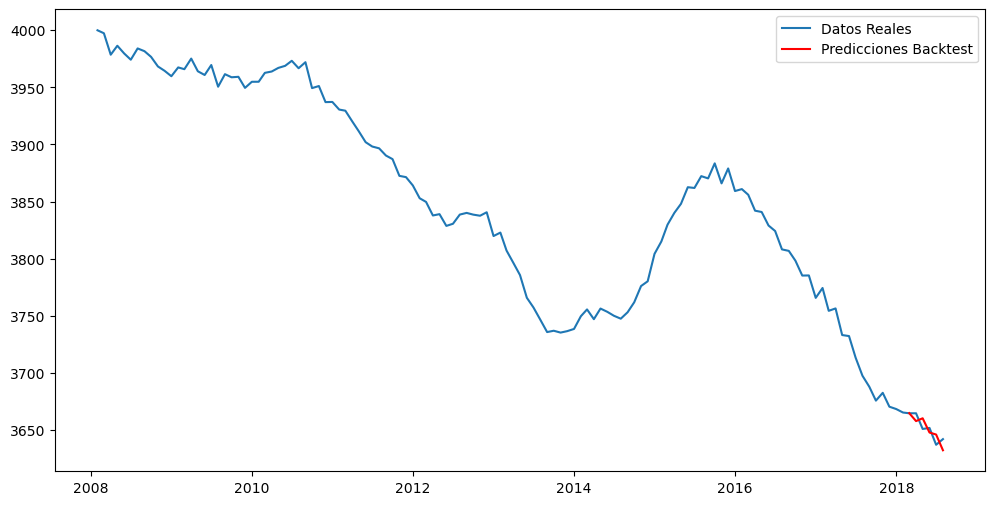

In [ ]:
forecaster = None
# Ejecutar el backtesting
metrica, predicciones_backtest, valores_reales = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = y,
                                    initial_train_size = len(y) - n_backtesting,
                                    steps              = steps,
                                    metric             = 'mean_squared_error'
                                 )

# Mostrar los resultados
print(f"Mean Squared Error: {metrica}")

# Graficar los resultados del backtesting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, label='Datos Reales')
ax.plot(y.index[len(y) - len(predicciones_backtest):], predicciones_backtest, label='Predicciones Backtest', color='red')
ax.legend()
plt.show()

Mean Squared Error: 52.76736567162407


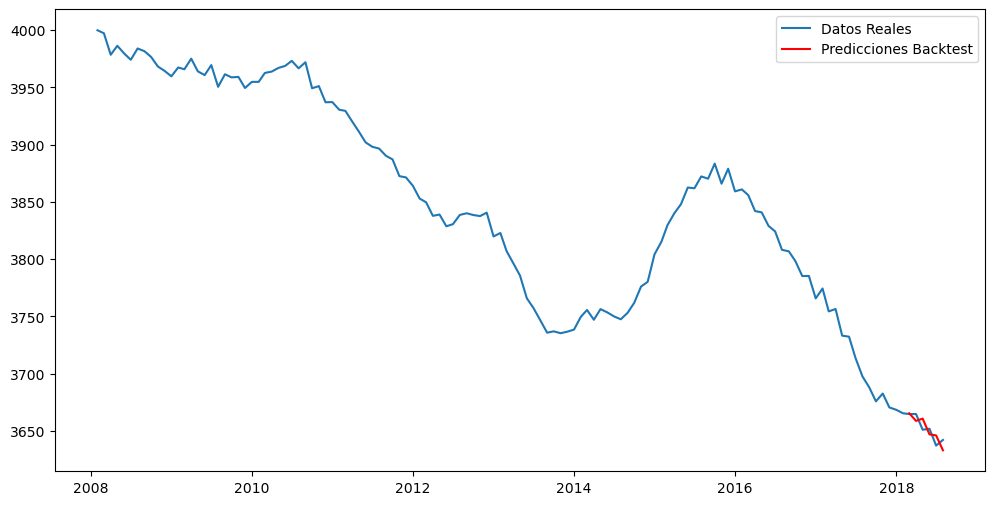

In [ ]:
# Definir el horizonte de predicción y la ventana de backtesting
steps = 1  # Número de pasos hacia adelante que quieres predecir
n_backtesting = 6  # Número de pasos hacia atrás que quieres usar para backtesting

# Preparar los datos
y = data["producto1"]

# Función de backtesting
def backtesting_forecaster(forecaster, y, initial_train_size, steps, metric):
    predictions = []
    true_values = []
    
    for i in range(initial_train_size, len(y) - steps + 1, steps):
        #train_y = y[:i] # Ventana Recursiva
        train_y = y[i - initial_train_size:i] # Ventana movil
        test_y = y[i:i+steps]
        
        # Crear un nuevo modelo para cada iteración

        forecaster = ETSModel(endog=train_y, 
                              error='add', 
                              trend='mul', 
                              seasonal='add', 
                              seasonal_periods=12)
        
        ets_result = forecaster.fit()
        pred = ets_result.forecast(steps)
        
        predictions.extend(pred)
        true_values.extend(test_y)
    
    if metric == 'mean_squared_error':
        return mean_squared_error(true_values, predictions), predictions, true_values

# Ejecutar el backtesting
metrica, predicciones_backtest, valores_reales = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = y,
                                    initial_train_size = len(y) - n_backtesting,
                                    steps              = steps,
                                    metric             = 'mean_squared_error'
                                 )

# Mostrar los resultados
print(f"Mean Squared Error: {metrica}")

# Graficar los resultados del backtesting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, label='Datos Reales')
ax.plot(y.index[len(y) - len(predicciones_backtest):], predicciones_backtest, label='Predicciones Backtest', color='red')
ax.legend()
plt.show()



Mean Squared Error: 54.403678243491065


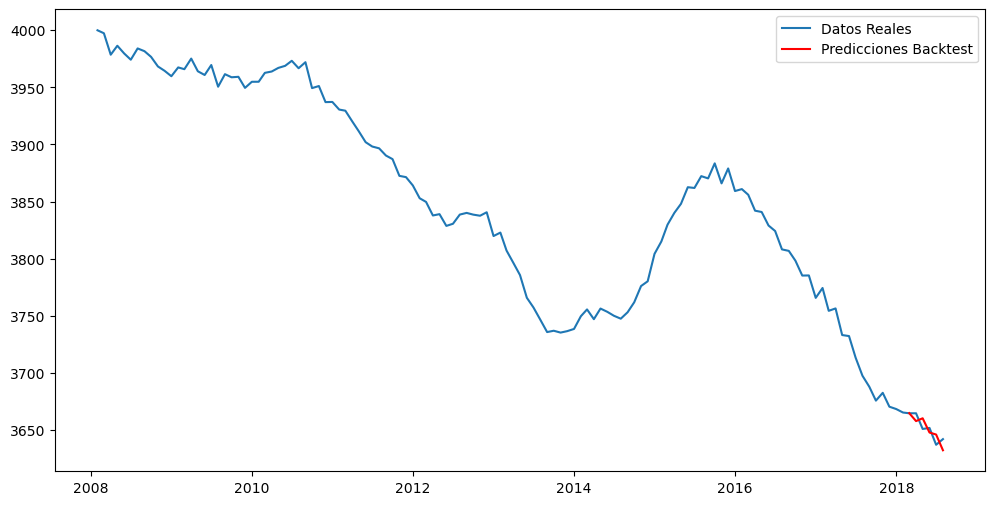

In [ ]:
# Definir el horizonte de predicción y la ventana de backtesting
steps = 1  # Número de pasos hacia adelante que quieres predecir
n_backtesting = 6 # Número de pasos hacia atrás que quieres usar para backtesting

# Preparar los datos
y = data["producto1"]


# Función de backtesting
def backtesting_forecaster(forecaster, y, initial_train_size, steps, metric):
    predictions = []
    true_values = []
    
    for i in range(initial_train_size, len(y) - steps + 1, steps):
        train_y = y[:i] # Ventana Recursiva
        #train_y = y[steps-1:i] # Ventana movil
        test_y = y[i:i+steps]
        
        # Crear un nuevo modelo para cada iteración

        forecaster = ETSModel(endog=train_y, 
                              error='mul', 
                              trend='add', 
                              seasonal='mul', 
                              seasonal_periods=12)
        
        ets_result = forecaster.fit()
        pred = ets_result.forecast(steps)
        
        predictions.extend(pred)
        true_values.extend(test_y)
    
    if metric == 'mean_squared_error':
        return mean_squared_error(true_values, predictions), predictions, true_values

# Ejecutar el backtesting
metrica, predicciones_backtest, valores_reales = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = y,
                                    initial_train_size = len(y) - n_backtesting,
                                    steps              = steps,
                                    metric             = 'mean_squared_error'
                                 )

# Mostrar los resultados
print(f"Mean Squared Error: {metrica}")

# Graficar los resultados del backtesting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, label='Datos Reales')
ax.plot(y.index[len(y) - len(predicciones_backtest):], predicciones_backtest, label='Predicciones Backtest', color='red')
ax.legend()
plt.show()

In [ ]:
len(y) - n_backtesting

121

In [ ]:
len(y) - steps + 1

127

In [ ]:
train_y = y[:i]
test_y = y[i:i+steps]

NameError: name 'i' is not defined

In [ ]:
y[n_backtesting:]

2008-07-31    3984.103665
2008-08-31    3981.695269
2008-09-30    3976.705402
2008-10-31    3968.330510
2008-11-30    3964.543238
                 ...     
2018-03-31    3664.610771
2018-04-30    3650.881839
2018-05-31    3651.788470
2018-06-30    3637.047639
2018-07-31    3641.990873
Freq: ME, Name: producto1, Length: 121, dtype: float64

In [ ]:
steps=1
a=[]
for i in range(len(y) - n_backtesting, len(y) - steps + 1, steps):
   a.append(i)

a


[124, 125, 126]

In [ ]:
train_y = y[steps:i]
test_y = y[i:i+steps]

In [ ]:
train_y = y[1:125]
train_y

2008-02-29    3997.400893
2008-03-31    3978.605317
2008-04-30    3986.454125
2008-05-31    3979.695678
2008-06-30    3974.222492
                 ...     
2018-01-31    3665.274600
2018-02-28    3664.625472
2018-03-31    3664.610771
2018-04-30    3650.881839
2018-05-31    3651.788470
Freq: ME, Name: producto1, Length: 124, dtype: float64

In [ ]:
test_y = y[126:126+steps]
test_y

2018-07-31    3641.990873
Freq: ME, Name: producto1, dtype: float64